In [1]:
import pandas as pd

train_df = pd.read_parquet('/kaggle/input/drw-crypto-market-prediction/train.parquet')
test_df = pd.read_parquet('/kaggle/input/drw-crypto-market-prediction/test.parquet')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (525886, 786)
Test shape: (538150, 786)


In [2]:
train_df.head()

,bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,...,X772,X773,X774,X775,X776,X777,X778,X779,X780,label
2023-03-01 00:00:00,15.283,8.425,176.405,44.984,221.389,0.181844,-0.637860,0.006652,0.136870,0.116698,...,0.333753,-0.009992,-0.695595,-0.444077,-0.191238,-0.184251,-0.471897,-0.625428,-0.553991,0.562539
2023-03-01 00:01:00,38.590,2.336,525.846,321.950,847.796,0.489497,-0.075619,0.431594,0.522400,0.475255,...,0.333657,-0.010040,-0.696226,-0.452866,-0.200082,-0.188929,-0.472842,-0.625832,-0.554426,0.533686
2023-03-01 00:02:00,0.442,60.250,159.227,136.369,295.596,0.260121,-0.444684,0.100695,0.224729,0.203282,...,0.333667,-0.010037,-0.696832,-0.461383,-0.208786,-0.193571,-0.473785,-0.626236,-0.554860,0.546505
2023-03-01 00:03:00,4.865,21.016,335.742,124.963,460.705,0.099976,-0.666728,-0.123858,0.019197,0.014459,...,0.333174,-0.010279,-0.697391,-0.469628,-0.217350,-0.198175,-0.474726,-0.626639,-0.555294,0.357703
2023-03-01 00:04:00,27.158,3.451,98.411,44.407,142.818,0.270893,-0.325973,0.116336,0.234311,0.214073,...,0.333171,-0.010283,-0.697940,-0.477622,-0.225780,-0.202745,-0.475666,-0.627043,-0.555728,0.362452


In [3]:
train_df.isnull().sum().sum()

np.int64(0)

In [4]:
test_df.isnull().sum().sum()

np.int64(0)

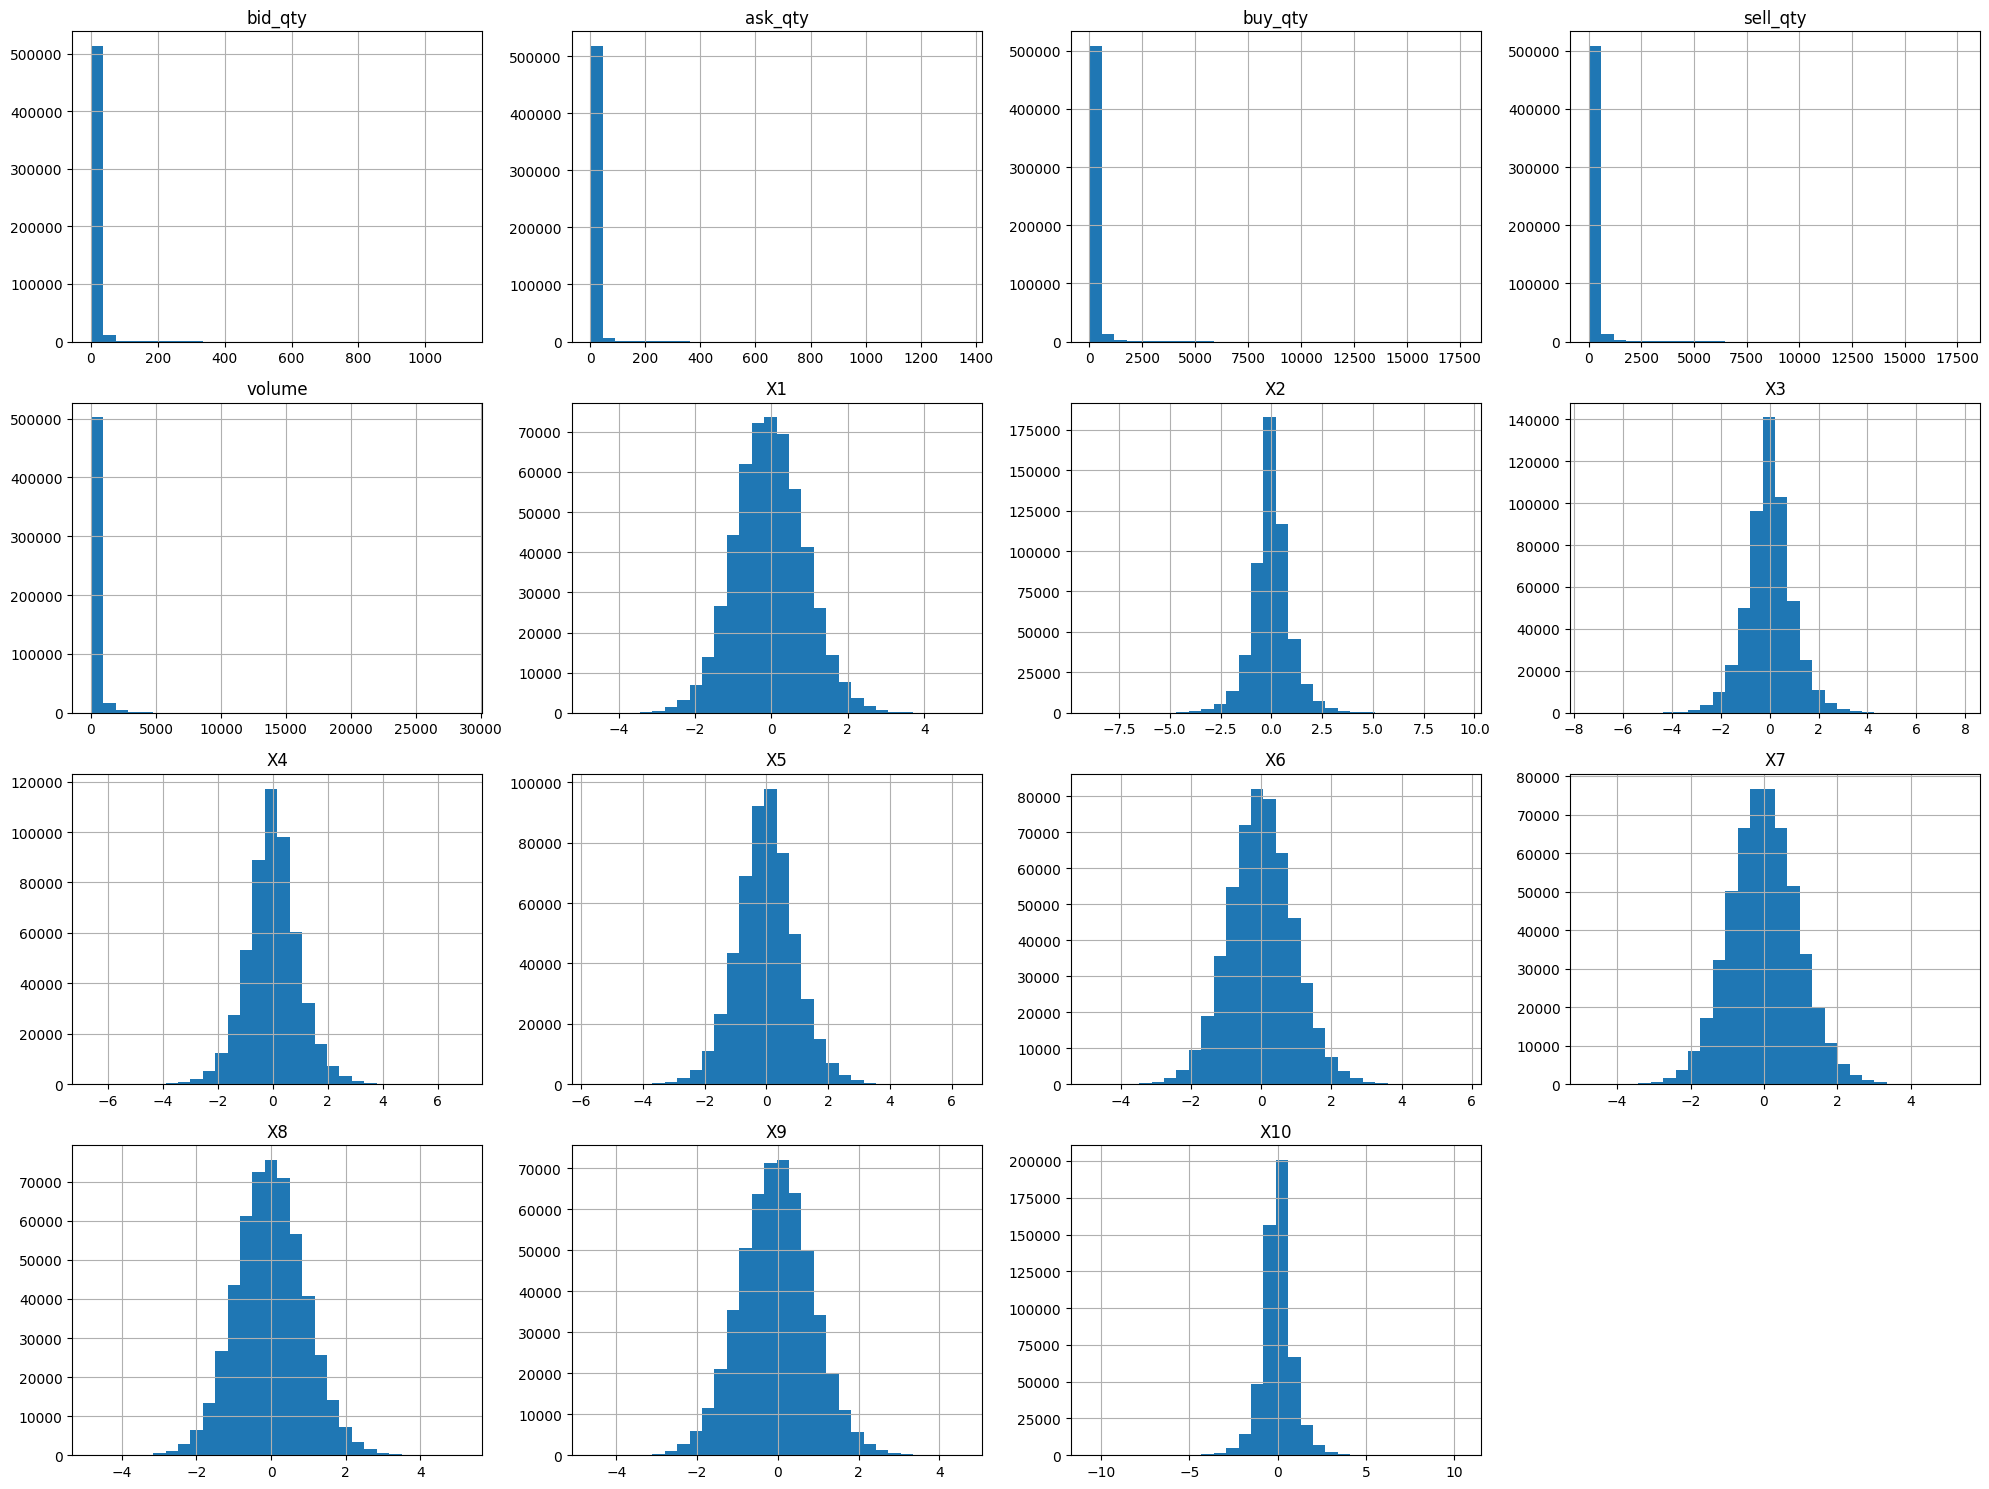

In [5]:
import matplotlib.pyplot as plt

main_cols=['bid_qty','ask_qty',	'buy_qty',	'sell_qty',	'volume', 'X1',	'X2', 'X3',	'X4', 'X5','X6','X7','X8','X9','X10']

train_df[main_cols].hist(bins=30, figsize=(20,15))
plt.title('гистограммы')
plt.tight_layout()

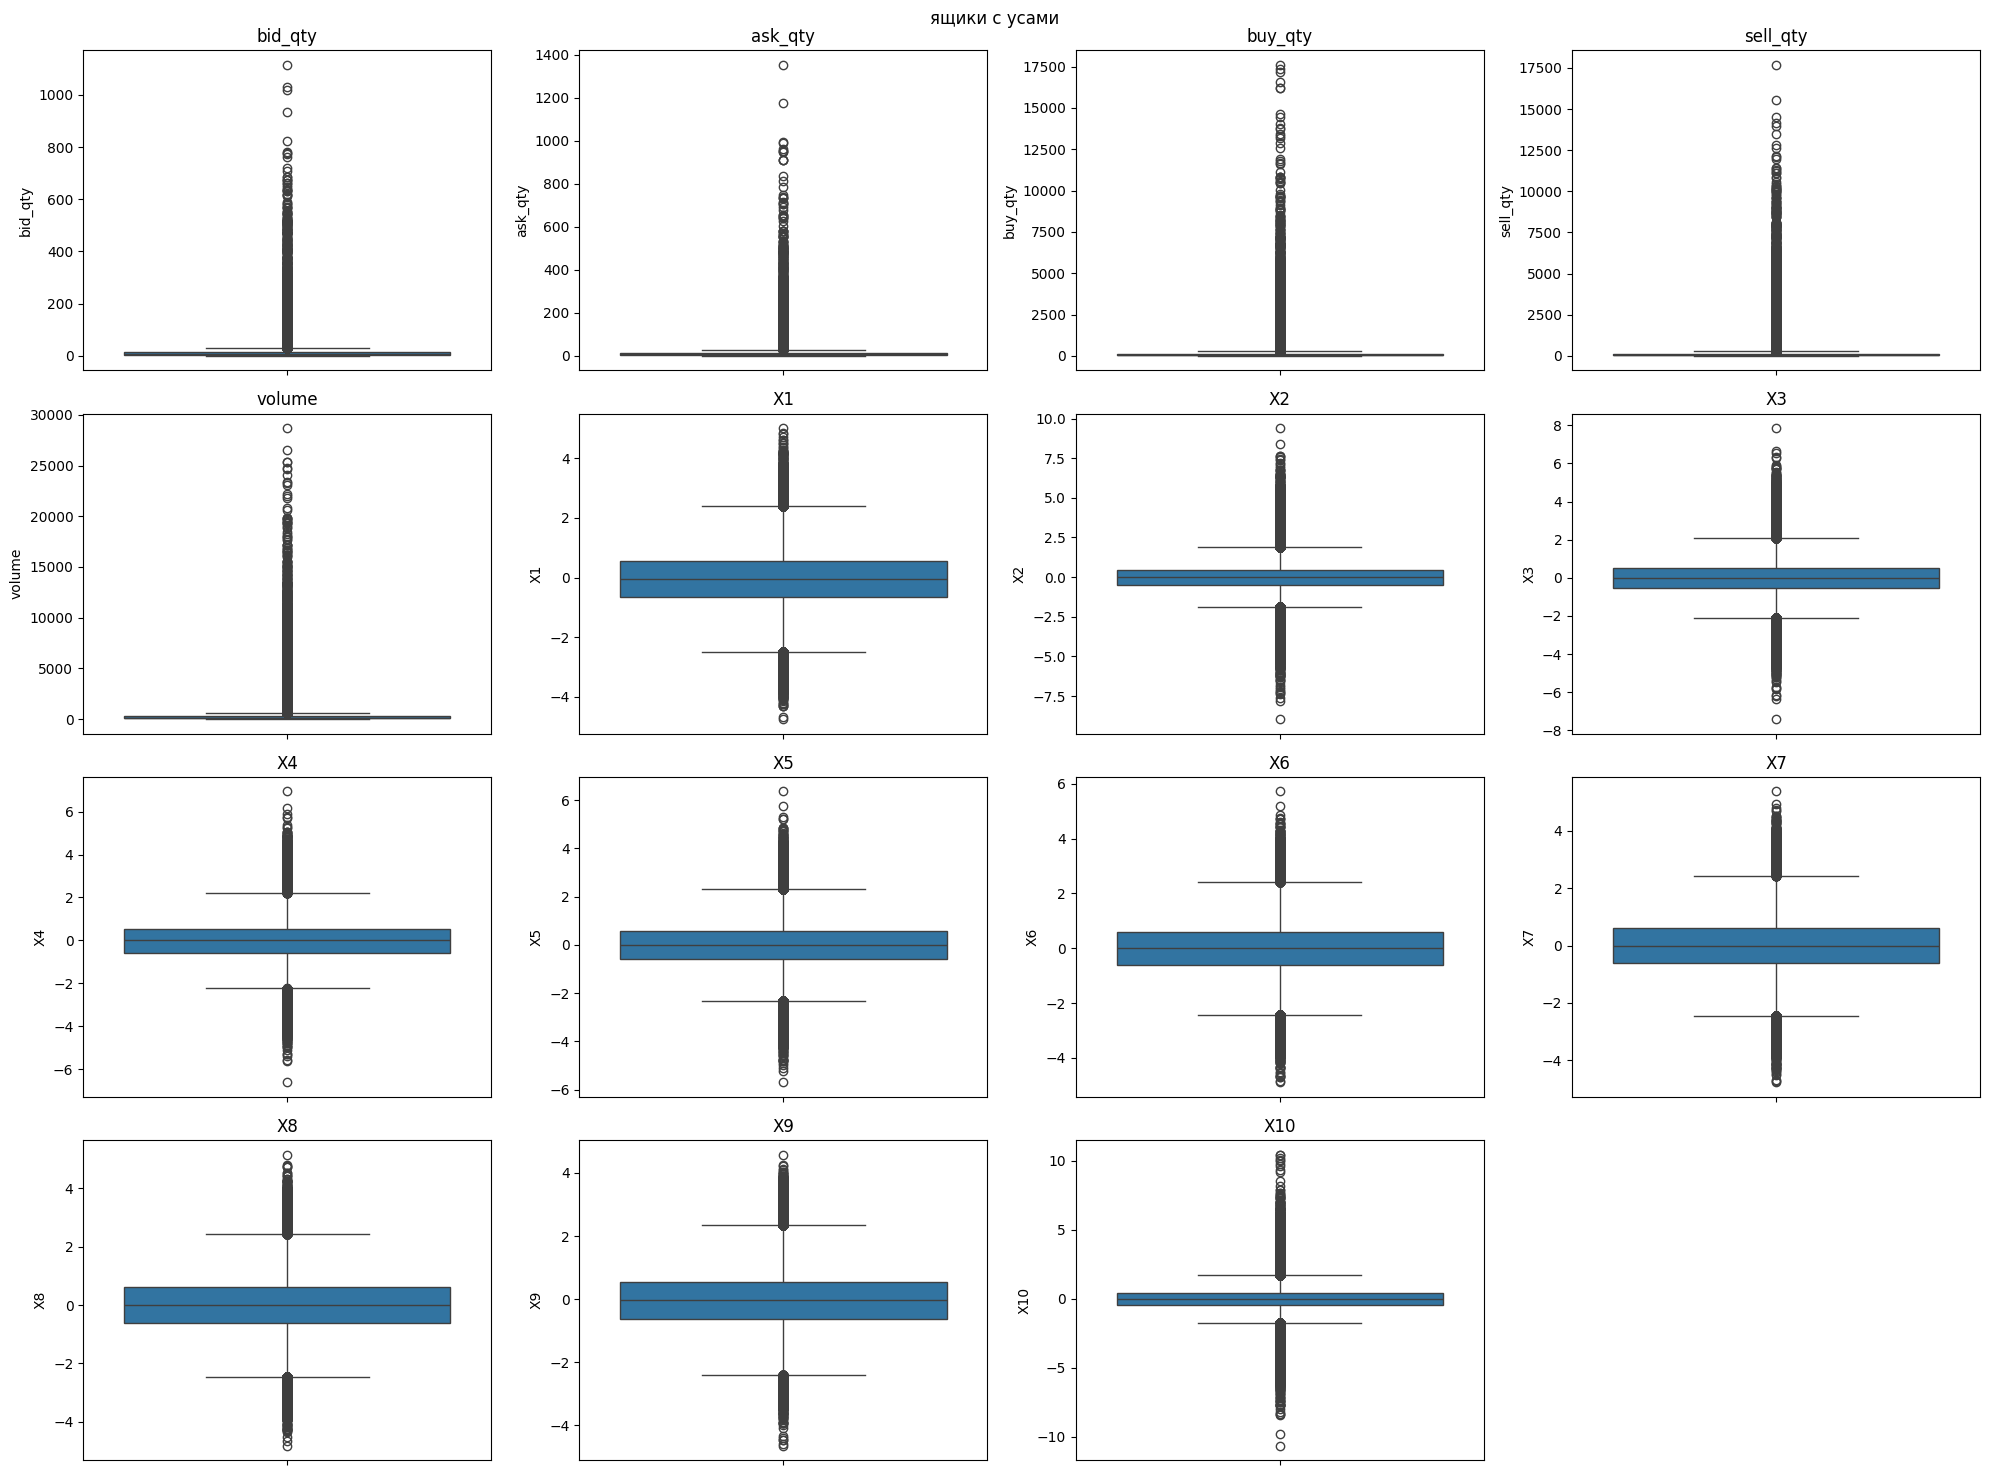

In [6]:
import seaborn as sns

plt.figure(figsize=(20,15))

for i,col in enumerate(main_cols,1):
    plt.subplot(4,4,i)
    sns.boxplot(data=train_df,y=col)
    plt.title(col)
plt.suptitle('ящики с усами')
plt.tight_layout()

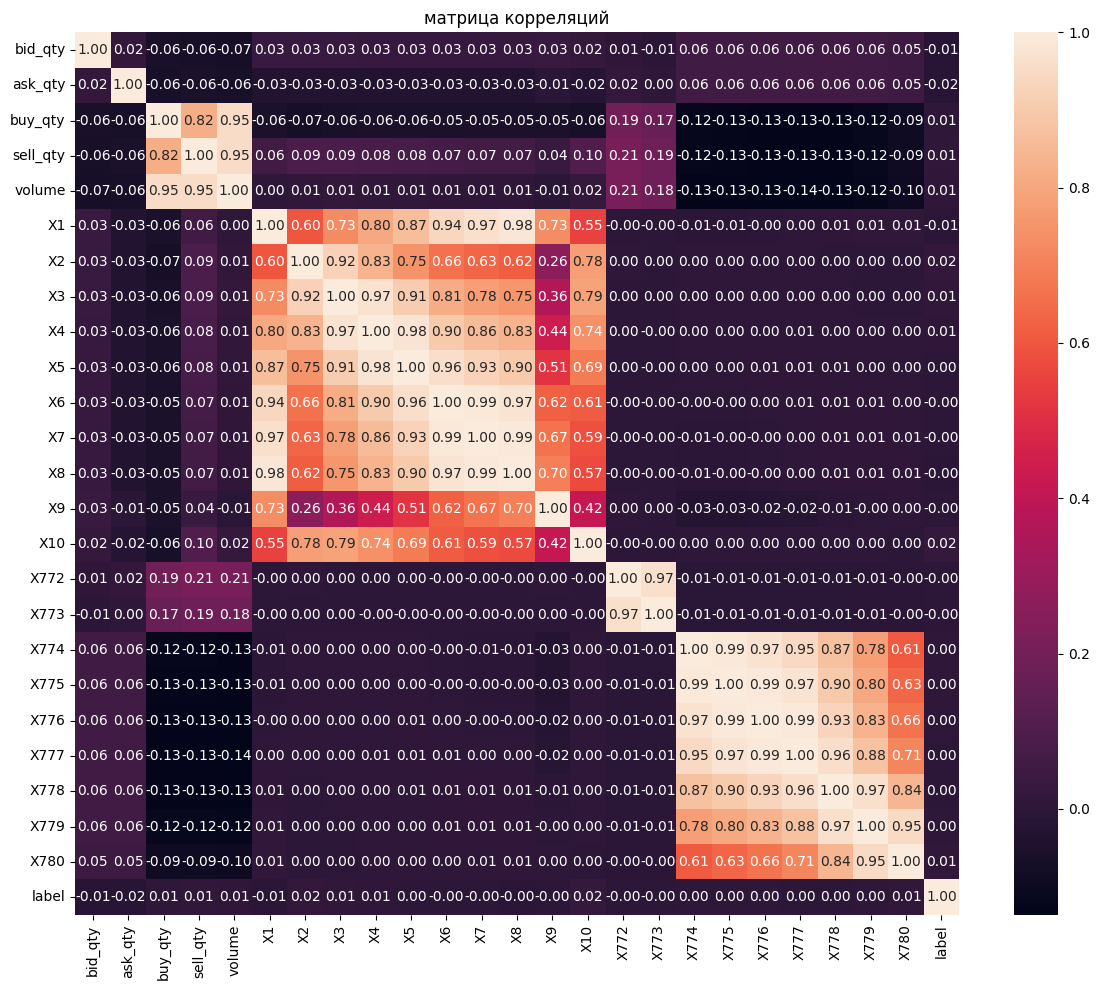

In [7]:
corr_cols=main_cols+['X772','X773','X774','X775','X776','X777','X778','X779','X780', 'label']

plt.figure(figsize=(12,10))
corr_m=train_df[corr_cols].corr()
sns.heatmap(corr_m, annot=True, fmt='.2f')
plt.title('матрица корреляций')
plt.tight_layout()

In [9]:
#новые признаки

train_df['bid_vs_ask']=train_df['bid_qty']/(train_df['ask_qty']+1e-10)
test_df['bid_vs_ask']=test_df['bid_qty']/(test_df['ask_qty']+1e-10)

train_df['buy_vs_sell']=train_df['buy_qty']/(train_df['sell_qty']+1e-10)
test_df['buy_vs_sell']=test_df['buy_qty']/(test_df['sell_qty']+1e-10)

train_df['pressure']=(train_df['buy_qty']-train_df['sell_qty'])/(train_df['volume']+1e-10)
test_df['pressure']=(test_df['buy_qty']-test_df['sell_qty'])/(test_df['volume']+1e-10)

In [11]:
# фильтруем признаки: убираем те, что слишком похожи друг на друга (корреляция > 0.8)

train_df_less=train_df.iloc[:len(train_df)//10]

X_features=[f'X{i}' for i in range(1,781)]
corr_m=train_df_less[X_features].corr().abs()

de=set()
for i in range(len(corr_m.columns)):
    for j in range(i+1, len(corr_m.columns)):
        if corr_m.iloc[i,j]>=0.8:
            de.add(corr_m.columns[j])
            
sel_x=[col for col in X_features if col not in de]
print(f'после удаления коррелирующих признаков осталось: {len(sel_x)} признаков')

после удаления коррелирующих признаков осталось: 116 признаков


In [12]:
# выбираем топ50 признаков с наибольшей корреляцией с целевой переменной

correlations=[]
for fe in sel_x:
    corr=train_df[fe].corr(train_df['label'])
    correlations.append((fe, abs(corr)))

correlations.sort(key=lambda x: x[1], reverse=True)

top50=[fe for fe,_ in correlations[:50]]

features=['bid_qty','ask_qty','buy_qty','sell_qty','volume','bid_vs_ask','buy_vs_sell','pressure']+top50

X_train=train_df[features]
y_train=train_df['label']

X_test=test_df[features]

print(f'признаков для модели: {len(features)}')

признаков для модели: 58


In [13]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [14]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from xgboost import XGBRegressor

tss=TimeSeriesSplit(n_splits=5)
scores=[]

for fold, (train_i, val_i) in enumerate(tss.split(X_train),1):
    X_tr, X_val=X_train.iloc[train_i], X_train.iloc[val_i]
    y_tr, y_val= y_train.iloc[train_i], y_train.iloc[val_i]

    model=XGBRegressor(
        n_estimators=200,
        learning_rate=0.05, 
        max_depth=6, 
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
    model.fit(X_tr, y_tr)
    pred=model.predict(X_val)
    p_corr=np.corrcoef(y_val,pred)[0,1]
    scores.append(p_corr)

print(f'средняя корреляция на TimeSeries CV: {np.mean(scores):.3f}')
print(f'стандартное отклонение: {np.std(scores):.3f}')
    

средняя корреляция на TimeSeries CV: 0.082
стандартное отклонение: 0.045


In [15]:
final_model=XGBRegressor(
    n_estimators=300,
    learning_rate=0.02,
    max_depth=5,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

final_model.fit(X_train[:500000], y_train[:500000])

ans = final_model.predict(X_test)

submission = pd.DataFrame({
    'ID': test_df.index,
    'prediction': ans
})

submission.to_csv('crypto_kaggle4.csv', index=False)